# CS-471 Machine Learning Assignment # 3  

**Submitted by:** Muhammad Sarmad Saleem  
**Class:** CS 12 A  
**CMS ID:** 411411  

---


# Spectral Clustering Practical Application in Identifying Social Networks Through a Graph-Based Dataset 
---

In [ ]:
!pip install node2vec


# Importing Libraries

Here importing libraries for displaying all networking graphs inn python

In [89]:
import networkx as nx
import numpy as np
from networkx.algorithms import approximation
from networkx.algorithms import reciprocity
import matplotlib.pyplot as plt
from collections import Counter
import random
from itertools import combinations, groupby
from node2vec import Node2Vec
from sklearn.metrics.cluster import adjusted_rand_score

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

import statistics

import warnings
warnings.filterwarnings('ignore')


## Resuable Functions 

### Loading Graphs

This function reads a graph from an edge list file and returns the graph object, its adjacency matrix, and basic graph information.


In [79]:


def load_graph_and_adjacency(file_path):
    """
    Load a graph from an edge list file and return its adjacency matrix.

    Parameters:
    - file_path (str): Path to the edge list file.

    Returns:
    - G (networkx.Graph): The loaded graph.
    - A (numpy.ndarray): The adjacency matrix of the graph.
    - info (dict): Basic information about the graph (number of nodes and edges).
    """
    # Load the graph
    G = nx.read_edgelist(file_path, nodetype=int)

    # Compute the adjacency matrix
    A = nx.to_numpy_array(G)

    return G, A


### Visualizing The Graphs

The `visualize_graph` function visualizes a graph using NetworkX and Matplotlib with customizable parameters for node size, font size, colors, transparency, and title.


In [80]:
c

### Computing Laplacian Matrix

The `compute_symmetric_normalized_laplacian` function computes the symmetric normalized Laplacian matrix \( L_{sym} \) for a given adjacency matrix \( A \) using the formula \( L_{sym} = I - D^{-1/2} A D^{-1/2} \), where \( D \) is the degree matrix.


In [81]:
import numpy as np
import networkx as nx

def compute_symmetric_normalized_laplacian(A):
    """
    Compute the symmetric normalized Laplacian matrix L_sym for a given adjacency matrix A.
    
    Parameters:
    - A (numpy.ndarray): The adjacency matrix of the graph.
    
    Returns:
    - L_sym (numpy.ndarray): The symmetric normalized Laplacian matrix.
    """
    # Compute the degree matrix D
    D = np.diag(np.sum(A, axis=1))  # Degree matrix D, diagonal with the sum of rows of A

    # Compute D^(-1/2) (Inverse square root of the degree matrix)
    D_inv_sqrt = np.linalg.inv(np.sqrt(D))

    # Compute the symmetric normalized Laplacian: L_sym = I - D^(-1/2) A D^(-1/2)
    L_sym = np.eye(A.shape[0]) - np.dot(D_inv_sqrt, np.dot(A, D_inv_sqrt))

    return L_sym



### Computing Eigenvalues & Eigenvectors

The `compute_eigenvalues_and_eigenvectors` function computes the eigenvalues and eigenvectors of a given matrix using NumPy's `np.linalg.eigh` method.


In [82]:
import numpy as np

def compute_eigenvalues_and_eigenvectors(matrix):
    """
    Compute the eigenvalues and eigenvectors for a given matrix.

    Parameters:
    - matrix (numpy.ndarray): The matrix for which eigenvalues and eigenvectors are computed.

    Returns:
    - eigenvalues (numpy.ndarray): The eigenvalues of the matrix.
    - eigenvectors (numpy.ndarray): The eigenvectors of the matrix.
    """
    # Compute the eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(matrix)

    return eigenvalues, eigenvectors


### Choosing Eigenvalues for Spectral Clustering

The `compute_eigengap` function estimates the number of clusters in a graph by calculating the "eigengap," which is the difference between consecutive eigenvalues of the Laplacian matrix. The largest gap indicates the optimal number of clusters, `k`. The `plot_eigenvalues` function visualizes the eigenvalues to help identify this eigengap.

- **`compute_eigengap(eigenvalues)`**: Estimates the number of clusters (`k`) based on the largest gap between consecutive eigenvalues.
- **`plot_eigenvalues(eigenvalues)`**: Visualizes the eigenvalues and shows the eigengap, aiding in the determination of the optimal `k`.


In [83]:
import numpy as np
import matplotlib.pyplot as plt

def compute_eigengap(eigenvalues):
    """
    Compute the eigengap heuristic to estimate the number of clusters k.

    Parameters:
    - eigenvalues (numpy.ndarray): The eigenvalues of the graph's Laplacian.

    Returns:
    - k (int): The estimated number of clusters.
    """
    # Calculate the differences between consecutive eigenvalues (eigengap)
    eigengaps = np.diff(eigenvalues)
    
    # The optimal k is the largest gap
    k = np.argmax(eigengaps) + 1  # +1 because the gap is between consecutive eigenvalues
    
    return k

def plot_eigenvalues(eigenvalues):
    """
    Plot the eigenvalues and show the eigengap.

    Parameters:
    - eigenvalues (numpy.ndarray): The eigenvalues of the Laplacian matrix.
    """
    plt.figure(figsize=(8, 6))
    plt.plot(eigenvalues, marker='o', linestyle='--', color='b')
    plt.title("Eigenvalues of the Laplacian Matrix")
    plt.xlabel("Index")
    plt.ylabel("Eigenvalue")
    plt.grid(True)
    plt.show()






### Spectral Clustering with k-means

The `spectral_clustering_kmeans` function performs spectral clustering by applying k-means on the first k eigenvectors of the Laplacian matrix. It computes the eigenvalues and eigenvectors of the Laplacian matrix, selects the first k eigenvectors, and then applies k-means to these eigenvectors for clustering.

The `visualize_clusters` function visualizes the graph with nodes colored according to their cluster labels.

In [84]:
from sklearn.cluster import KMeans
import numpy as np
import networkx as nx

def spectral_clustering_kmeans(L, k):
    """
    Perform spectral clustering using k-means on the first k eigenvectors of the Laplacian matrix.

    Parameters:
    - L (numpy.ndarray): The Laplacian matrix (e.g., symmetric normalized Laplacian).
    - k (int): The number of clusters to form.

    Returns:
    - labels (numpy.ndarray): The cluster labels for each node.
    - kmeans (KMeans): The fitted k-means model.
    """
    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(L)

    # Select the first k eigenvectors (corresponding to the k smallest eigenvalues)
    U = eigenvectors[:, :k]

    # Apply k-means clustering to the first k eigenvectors
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(U)

    # Get the cluster labels
    labels = kmeans.labels_

    return labels, kmeans, U

def visualize_clusters(G, labels, k):
    """
    Visualize the graph with node colors corresponding to their cluster labels.

    Parameters:
    - G (networkx.Graph): The graph to visualize.
    - labels (numpy.ndarray): The cluster labels for each node.
    - k (int): The number of clusters.
    """
    # Create a color map based on the cluster labels
    node_colors = [plt.cm.jet(label / k) for label in labels]

    # Plot the graph with node colors based on clusters
    plt.figure(figsize=(10, 8))
    nx.draw(G, 
            with_labels=True, 
            node_size=50, 
            font_size=8, 
            font_color='black', 
            node_color=node_colors, 
            edge_color='gray', 
            alpha=0.5)

    plt.title(f"Graph with {k} Clusters from Spectral Clustering")
    plt.show()


### Evaluation Metrics

The evaluation functions assess clustering quality using various metrics: the **Silhouette Score** measures cluster cohesion and separation, **Modularity** evaluates the strength of community divisions in graphs, **Normalized Mutual Information (NMI)** compares clustering results with ground truth, **Adjusted Rand Index (ARI)** quantifies clustering similarity adjusted for chance, and **Intra/Inter-cluster Distances** calculate average distances within and between clusters. These metrics provide insights into the clustering performance and structure.


In [85]:
import numpy as np
from sklearn.metrics import silhouette_score, normalized_mutual_info_score, adjusted_rand_score
from collections import defaultdict
import networkx as nx

def compute_silhouette_score(U, labels):
    """
    Compute the Silhouette Score for clustering.

    Parameters:
        U (numpy.ndarray): The reduced feature matrix.
        labels (list or array): Cluster labels for each data point.

    Returns:
        float: Silhouette Score.
    """
    return silhouette_score(U, labels)

def compute_modularity(G, labels):
    """
    Compute the modularity of a graph given its clustering labels.

    Parameters:
        G (networkx.Graph): The input graph.
        labels (list or array): Cluster labels for each node in G.

    Returns:
        float: The modularity score.
    """
    communities = defaultdict(list)
    for node, label in zip(G.nodes, labels):
        communities[label].append(node)
    community_list = [set(nodes) for nodes in communities.values()]
    return nx.algorithms.community.quality.modularity(G, community_list)

def compute_nmi(true_labels, predicted_labels):
    """
    Compute the Normalized Mutual Information (NMI).

    Parameters:
        true_labels (list or array): Ground truth labels.
        predicted_labels (list or array): Predicted cluster labels.

    Returns:
        float: Normalized Mutual Information score.
    """
    return normalized_mutual_info_score(true_labels, predicted_labels)

def compute_ari(true_labels, predicted_labels):
    """
    Compute the Adjusted Rand Index (ARI).

    Parameters:
        true_labels (list or array): Ground truth labels.
        predicted_labels (list or array): Predicted cluster labels.

    Returns:
        float: Adjusted Rand Index.
    """
    return adjusted_rand_score(true_labels, predicted_labels)

def compute_intra_inter_cluster_distances(U, labels):
    """
    Compute the average intra-cluster and inter-cluster distances.

    Parameters:
        U (numpy.ndarray): The reduced feature matrix.
        labels (list or array): Cluster labels for each data point.

    Returns:
        tuple: (Average intra-cluster distance, Average inter-cluster distance)
    """
    n_clusters = len(set(labels))
    intra_cluster_distances = []
    inter_cluster_distances = []

    for cluster in range(n_clusters):
        cluster_points = U[np.array(labels) == cluster]
        other_points = U[np.array(labels) != cluster]
        if len(cluster_points) > 1:
            intra_distance = np.mean(
                np.linalg.norm(cluster_points[:, None] - cluster_points[None, :], axis=2)
            )
            intra_cluster_distances.append(intra_distance)
        if len(cluster_points) > 0 and len(other_points) > 0:
            inter_distance = np.mean(
                np.linalg.norm(cluster_points[:, None] - other_points[None, :], axis=2)
            )
            inter_cluster_distances.append(inter_distance)

    avg_intra_cluster_distance = np.mean(intra_cluster_distances) if intra_cluster_distances else 0
    avg_inter_cluster_distance = np.mean(inter_cluster_distances) if inter_cluster_distances else 0

    return avg_intra_cluster_distance, avg_inter_cluster_distance


### Combined Function for all implementation to display

In [138]:
# def load_true_labels_from_circles(circles_filename):
#     """
#     Load ground truth labels from a circles file.

#     Parameters:
#     - circles_filename (str): Path to the file containing circle information.

#     Returns:
#     - true_labels (dict): Mapping of node IDs to their corresponding cluster (circle) labels.
#     """
#     true_labels = {}
#     with open(circles_filename, 'r') as f:
#         for line in f:
#             parts = line.split()
#             circle_name = parts[0]
#             nodes = map(int, parts[1:])
            
#             # Assign the same label to all nodes in the same circle
#             for node in nodes:
#                 true_labels[node] = int(circle_name[6:])  # Extract circle number from "circle0", "circle1", etc.
    
#     return true_labels


# def perform_spectral_clustering(filename):
    
#     G, A=load_graph_and_adjacency(filename)
#     print("Visualization for The ",filename)
#     visualize_graph(G, title=filename)
#     L_sym=compute_symmetric_normalized_laplacian(A)
#     eigenvalues, eigenvectors = compute_eigenvalues_and_eigenvectors(L_sym)
#     print("Plotting Eigen Values")
#     plot_eigenvalues(eigenvalues)
#     k=compute_eigengap(eigenvalues)
#     print("K value chosen after gap: ",k)
#     # Perform spectral clustering using k-means
#     labels, kmeans, U = spectral_clustering_kmeans(L_sym, k)
#     # Visualize the graph with node colors based on clusters

#     G = nx.read_edgelist(filename, nodetype=int)
#     print("Visualization of Clusters after Spectral Clustering for : ",filename)
#     visualize_clusters(G, labels, k)
#     # Compute the Silhouette Score
#     silhouette = compute_silhouette_score(U, labels)
#     print(f"Silhouette Score: {silhouette:.4f}")

#     # Compute the Modularity
#     modularity = compute_modularity(G, labels)
#     print(f"Modularity: {modularity:.4f}")

#     # Load the ground truth labels
#     true_labels = np.loadtxt(filename, dtype=int)
#     print("True Labels: ",true_labels)

   

#     # # Compute the Normalized Mutual Information (NMI)
#     # nmi = compute_nmi(true_labels, labels)
#     # print(f"NMI: {nmi:.4f}")

#     # # Compute the Adjusted Rand Index (ARI)
#     # ari = compute_ari(true_labels, labels)
#     # print(f"ARI: {ari:.4f}")

#     # Compute the intra-cluster and inter-cluster distances
#     intra_cluster_distance, inter_cluster_distance = compute_intra_inter_cluster_distances(U, labels)
#     print(f"Average Intra-Cluster Distance: {intra_cluster_distance:.4f}")
#     print(f"Average Inter-Cluster Distance: {inter_cluster_distance:.4f}")
    


import numpy as np
import networkx as nx
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

def load_true_labels_from_circles(circles_filename):
    """
    Load ground truth labels from a circles file.

    Parameters:
    - circles_filename (str): Path to the file containing circle information.

    Returns:
    - true_labels (dict): Mapping of node IDs to their corresponding cluster (circle) labels.
    """
    true_labels = {}
    with open(circles_filename, 'r') as f:
        for line in f:
            parts = line.split()
            circle_name = parts[0]
            nodes = map(int, parts[1:])
            
            # Assign the same label to all nodes in the same circle
            circle_id = int(circle_name[6:])  # Extract circle number from "circle0", "circle1", etc.
            for node in nodes:
                true_labels[node] = circle_id
    
    return true_labels


def convert_dict_to_array(true_labels, max_node_id):
    """
    Convert true labels dictionary to a 1D array where index corresponds to node id.
    
    Parameters:
    - true_labels (dict): Mapping of node IDs to cluster labels.
    - max_node_id (int): Maximum node id in the graph.
    
    Returns:
    - true_labels_array (np.ndarray): 1D array of true labels for each node.
    """
    true_labels_array = np.zeros(max_node_id + 1, dtype=int)  # Initialize array of zeros
    for node, label in true_labels.items():
        true_labels_array[node] = label
    return true_labels_array


def perform_spectral_clustering(filename,truelabel_filename ):
    # Load graph and adjacency matrix
    G, A = load_graph_and_adjacency(filename)
    print("Visualization for The ", filename)
    visualize_graph(G, title=filename)
    
    L_sym = compute_symmetric_normalized_laplacian(A)
    eigenvalues, eigenvectors = compute_eigenvalues_and_eigenvectors(L_sym)
    
    print("Plotting Eigen Values")
    plot_eigenvalues(eigenvalues)
    
    k = compute_eigengap(eigenvalues)
    print("K value chosen after gap: ", k)
    
    # Perform spectral clustering using k-means
    labels, kmeans, U = spectral_clustering_kmeans(L_sym, k)
    
    # Visualize the graph with node colors based on clusters
    G = nx.read_edgelist(filename, nodetype=int)
    print("Visualization of Clusters after Spectral Clustering for: ", filename)
    visualize_clusters(G, labels, k)
    
    # Compute the Silhouette Score
    silhouette = compute_silhouette_score(U, labels)
    print(f"Silhouette Score: {silhouette:.4f}")

    # Compute the Modularity
    modularity = compute_modularity(G, labels)
    print(f"Modularity: {modularity:.4f}")

    # Load the ground truth labels from circles file
    true_labels = load_true_labels_from_circles(truelabel_filename)
    print("True Labels (as dict): ", true_labels)
    
    # Convert true_labels to a 1D array
    max_node_id = max(true_labels.keys())  # Get the maximum node ID
    true_labels_array = convert_dict_to_array(true_labels, max_node_id)
   

    # Ensure labels are in the correct shape (1D array of same length)
    labels = np.array(labels)  # Convert labels to a numpy array if not already
    if labels.ndim != 1:
        labels = labels.flatten()  # Ensure it is a 1D array
    
    # Match the number of nodes in true_labels_array and spectral clustering labels
    # This step ensures that both arrays have the same number of nodes
    true_labels_array = true_labels_array[:len(labels)]  # Trim or adjust the true labels array if needed
    
    # Compute the Normalized Mutual Information (NMI)
    nmi = normalized_mutual_info_score(true_labels_array, labels)
    print(f"NMI: {nmi:.4f}")

    # Compute the Adjusted Rand Index (ARI)
    ari = adjusted_rand_score(true_labels_array, labels)
    print(f"ARI: {ari:.4f}")

    # Compute the intra-cluster and inter-cluster distances
    intra_cluster_distance, inter_cluster_distance = compute_intra_inter_cluster_distances(U, labels)
    print(f"Average Intra-Cluster Distance: {intra_cluster_distance:.4f}")
    print(f"Average Inter-Cluster Distance: {inter_cluster_distance:.4f}")


## Spectral Clustering on individual Ego Networks

### 0 Ego Network

Visualization for The  dataset/0.edges


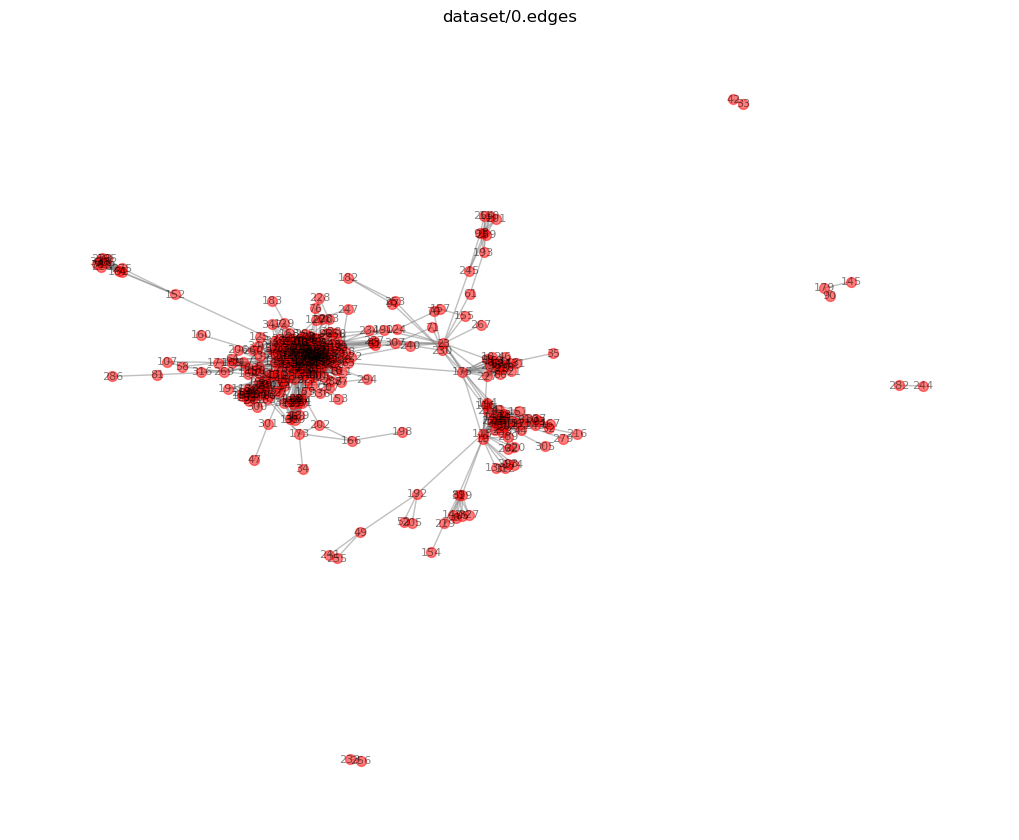

Plotting Eigen Values


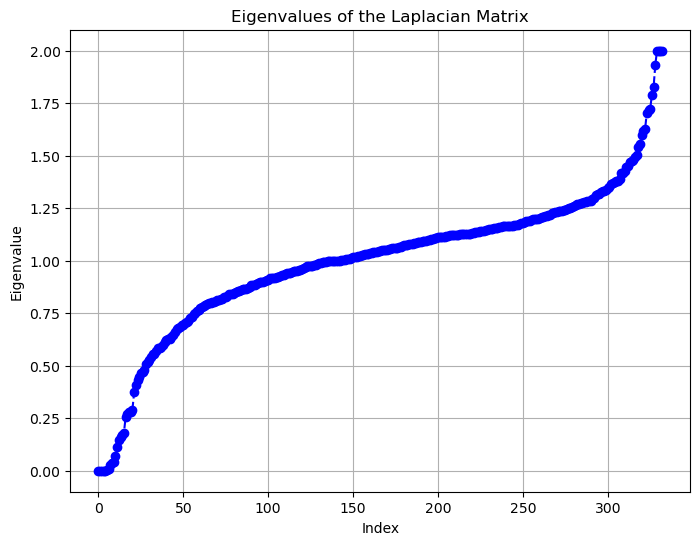

K value chosen after gap:  328
Visualization of Clusters after Spectral Clustering for:  dataset/0.edges


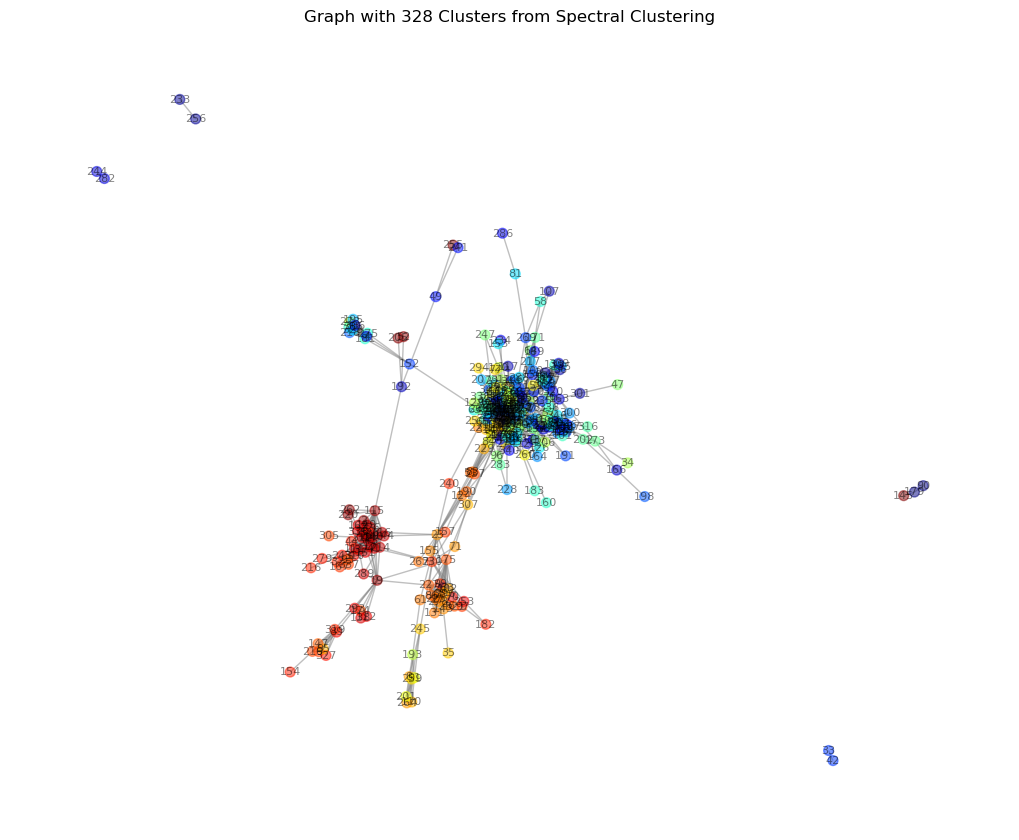

Silhouette Score: 0.0192
Modularity: -0.0042
True Labels (as dict):  {71: 0, 215: 0, 54: 11, 61: 0, 298: 11, 229: 0, 81: 0, 253: 0, 193: 0, 97: 11, 264: 0, 29: 0, 132: 0, 110: 0, 163: 0, 259: 0, 183: 15, 334: 0, 245: 0, 222: 0, 173: 16, 155: 2, 99: 2, 327: 2, 140: 2, 116: 2, 147: 2, 144: 2, 150: 2, 270: 2, 51: 3, 83: 3, 237: 3, 125: 15, 344: 4, 295: 4, 257: 4, 55: 15, 122: 15, 223: 4, 59: 4, 268: 4, 280: 15, 84: 4, 156: 4, 258: 16, 236: 15, 250: 4, 239: 4, 69: 15, 23: 15, 337: 6, 289: 6, 93: 19, 17: 19, 111: 6, 52: 17, 137: 19, 343: 19, 192: 6, 35: 6, 326: 19, 310: 6, 214: 19, 32: 6, 115: 19, 321: 6, 209: 6, 312: 19, 41: 19, 20: 19, 225: 7, 46: 7, 282: 20, 336: 9, 204: 9, 74: 9, 206: 9, 292: 9, 146: 15, 154: 9, 164: 9, 279: 9, 73: 9, 42: 10, 14: 10, 216: 10, 2: 10, 324: 11, 265: 11, 161: 11, 76: 11, 165: 11, 199: 11, 203: 11, 13: 11, 66: 11, 113: 11, 252: 11, 313: 11, 238: 11, 158: 11, 240: 11, 331: 11, 332: 11, 134: 11, 218: 11, 118: 11, 235: 11, 311: 11, 151: 11, 308: 15, 212: 11, 70

In [139]:
perform_spectral_clustering("dataset/0.edges","dataset/0.circles")

#### 107 Edge Network

Visualization for The  dataset/107.edges


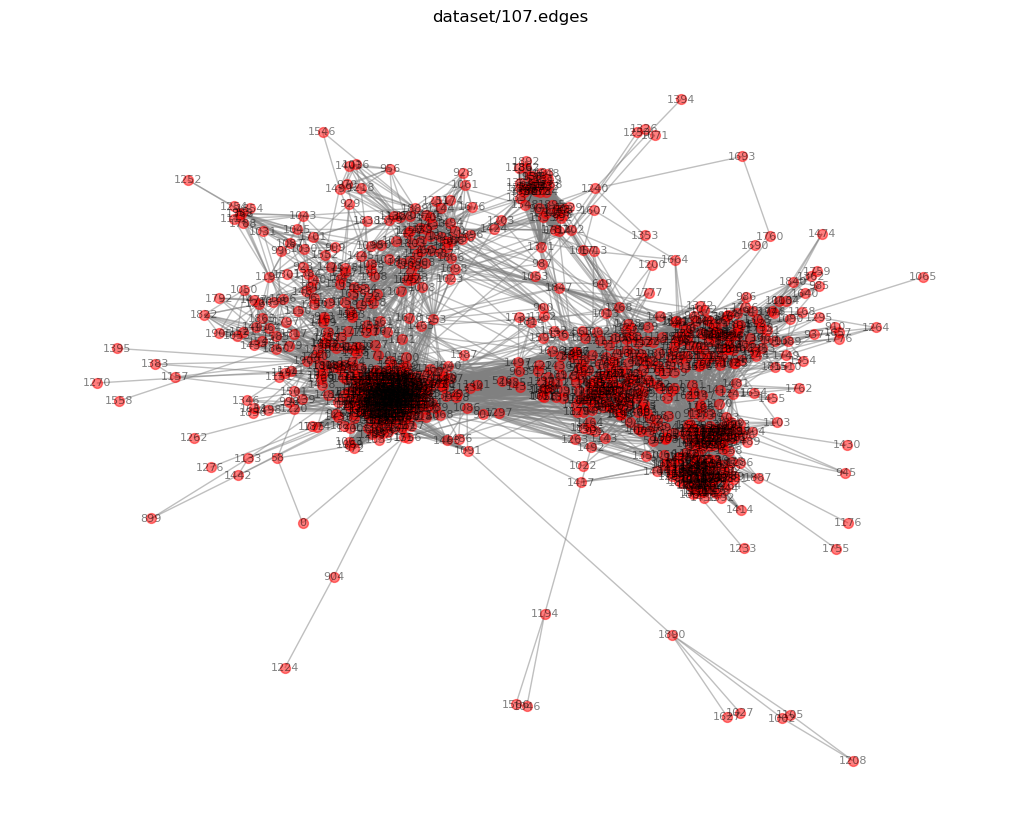

Plotting Eigen Values


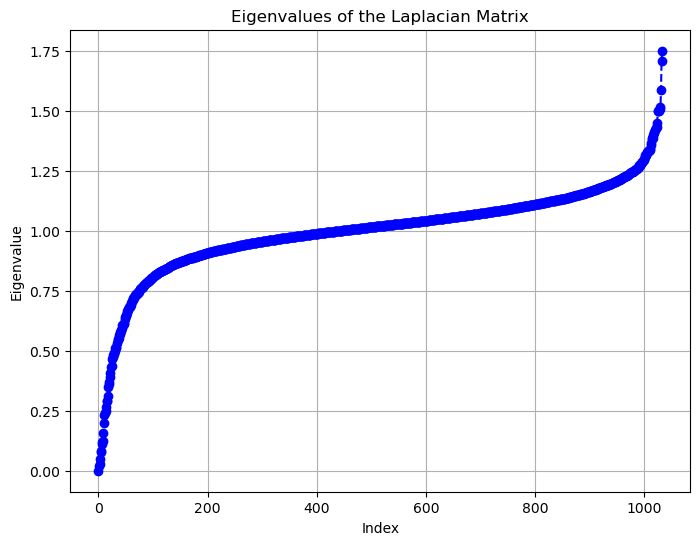

K value chosen after gap:  1032
Visualization of Clusters after Spectral Clustering for:  dataset/107.edges


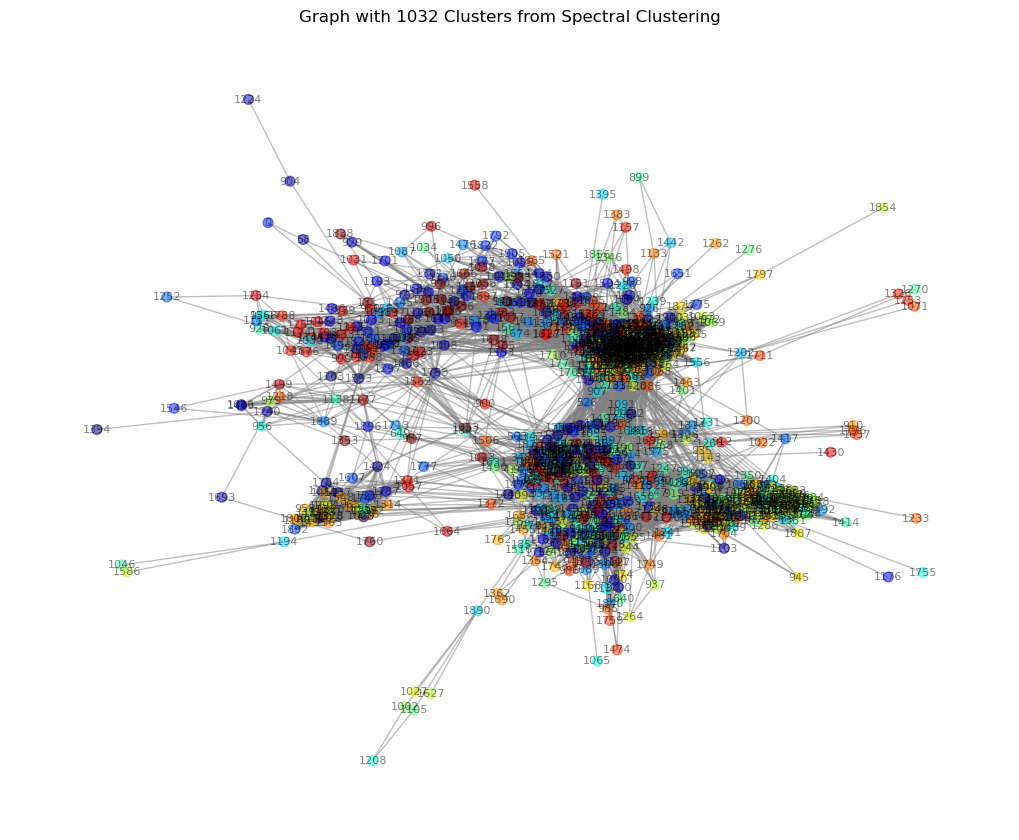

Silhouette Score: 0.0016
Modularity: -0.0017
True Labels (as dict):  {1043: 0, 1045: 0, 1030: 0, 1252: 0, 1254: 0, 1368: 0, 1197: 6, 955: 0, 1111: 0, 1384: 6, 1410: 1, 1144: 6, 950: 6, 1385: 1, 1174: 6, 1087: 6, 563: 3, 1684: 6, 1676: 6, 1555: 6, 1549: 3, 389: 1, 1013: 1, 1251: 6, 1031: 6, 1421: 6, 1469: 2, 1504: 2, 1727: 5, 1183: 2, 1052: 2, 1807: 2, 913: 2, 1263: 2, 1690: 2, 1035: 2, 1531: 2, 1699: 2, 1444: 2, 1738: 2, 1745: 2, 1760: 2, 1429: 2, 987: 2, 1542: 2, 1320: 3, 1616: 3, 1025: 3, 976: 3, 651: 3, 1237: 3, 1223: 3, 566: 3, 1881: 3, 1080: 3, 0: 3, 1142: 3, 517: 3, 1155: 3, 1408: 3, 1692: 3, 914: 3, 348: 3, 915: 3, 420: 3, 363: 3, 1487: 3, 606: 3, 1766: 3, 366: 3, 1113: 3, 1679: 3, 1882: 3, 428: 3, 58: 3, 1114: 3, 1574: 3, 1332: 3, 1387: 3, 1767: 3, 1179: 3, 1177: 4, 1896: 4, 1053: 4, 1138: 4, 1057: 4, 1403: 4, 979: 4, 1016: 4, 1664: 4, 1607: 4, 1231: 5, 1060: 5, 1099: 5, 1227: 5, 1158: 5, 1891: 5, 1635: 5, 1423: 5, 1691: 5, 1120: 5, 1413: 5, 1115: 5, 1215: 5, 1436: 5, 1899: 5, 

In [142]:
perform_spectral_clustering("dataset/107.edges","dataset/107.circles")

#### 348 Edge Network

Visualization for The  dataset/348.edges


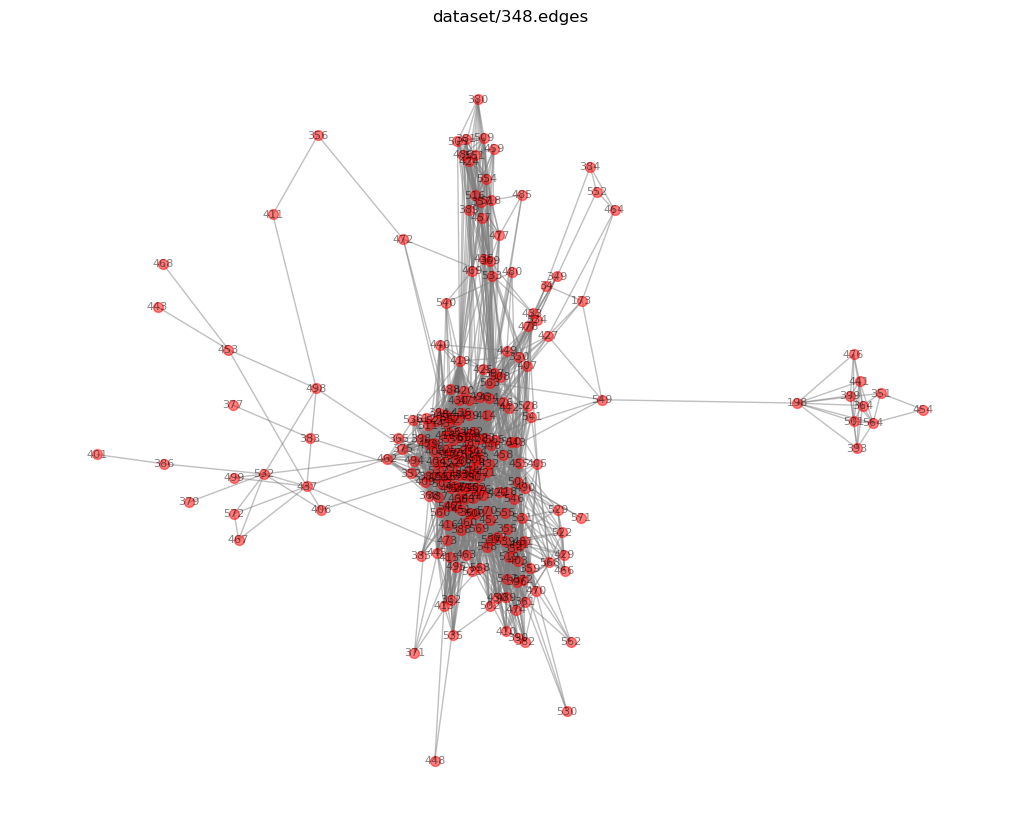

Plotting Eigen Values


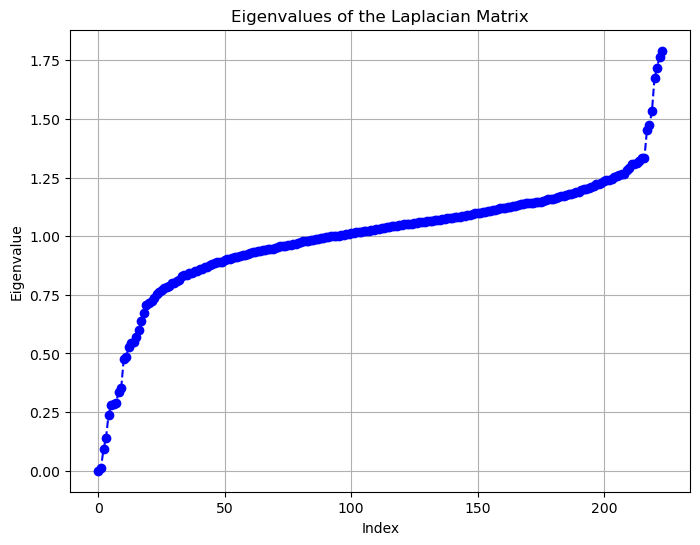

K value chosen after gap:  220
Visualization of Clusters after Spectral Clustering for:  dataset/348.edges


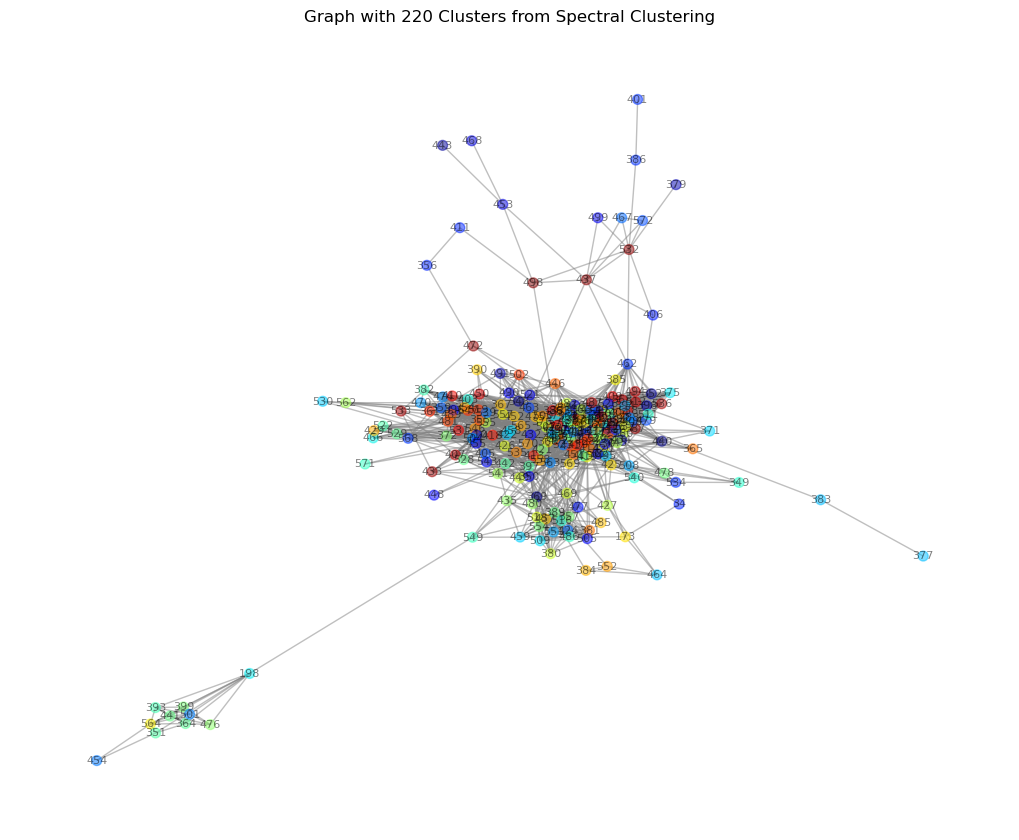

Silhouette Score: 0.0142
Modularity: -0.0060
True Labels (as dict):  {513: 11, 475: 13, 388: 13, 373: 11, 431: 11, 463: 13, 461: 11, 517: 11, 400: 11, 391: 11, 450: 13, 500: 13, 452: 13, 366: 11, 414: 11, 408: 11, 525: 11, 524: 11, 387: 11, 376: 13, 378: 11, 526: 13, 449: 13, 412: 13, 536: 11, 439: 11, 446: 11, 509: 5, 489: 13, 398: 11, 419: 11, 405: 8, 554: 5, 396: 13, 520: 11, 458: 13, 533: 13, 540: 1, 438: 13, 568: 13, 356: 1, 469: 5, 442: 1, 502: 8, 361: 13, 528: 13, 571: 1, 553: 13, 565: 13, 514: 13, 558: 13, 415: 11, 508: 11, 497: 13, 432: 13, 375: 2, 493: 11, 477: 5, 504: 13, 478: 8, 445: 11, 537: 11, 354: 13, 473: 11, 547: 13, 560: 11, 532: 1, 529: 1, 484: 11, 494: 11, 451: 12, 420: 12, 392: 11, 436: 11, 485: 5, 516: 5, 491: 8, 506: 13, 362: 11, 544: 13, 481: 13, 426: 7, 466: 1, 372: 13, 519: 13, 535: 11, 462: 11, 570: 13, 352: 11, 355: 13, 390: 13, 417: 11, 363: 13, 522: 8, 421: 12, 476: 6, 424: 5, 542: 11, 487: 11, 402: 13, 534: 8, 397: 13, 566: 13, 551: 5, 395: 11, 437: 1, 5

In [143]:
perform_spectral_clustering("dataset/348.edges","dataset/348.circles")

#### 414 Edge Network

Visualization for The  dataset/414.edges


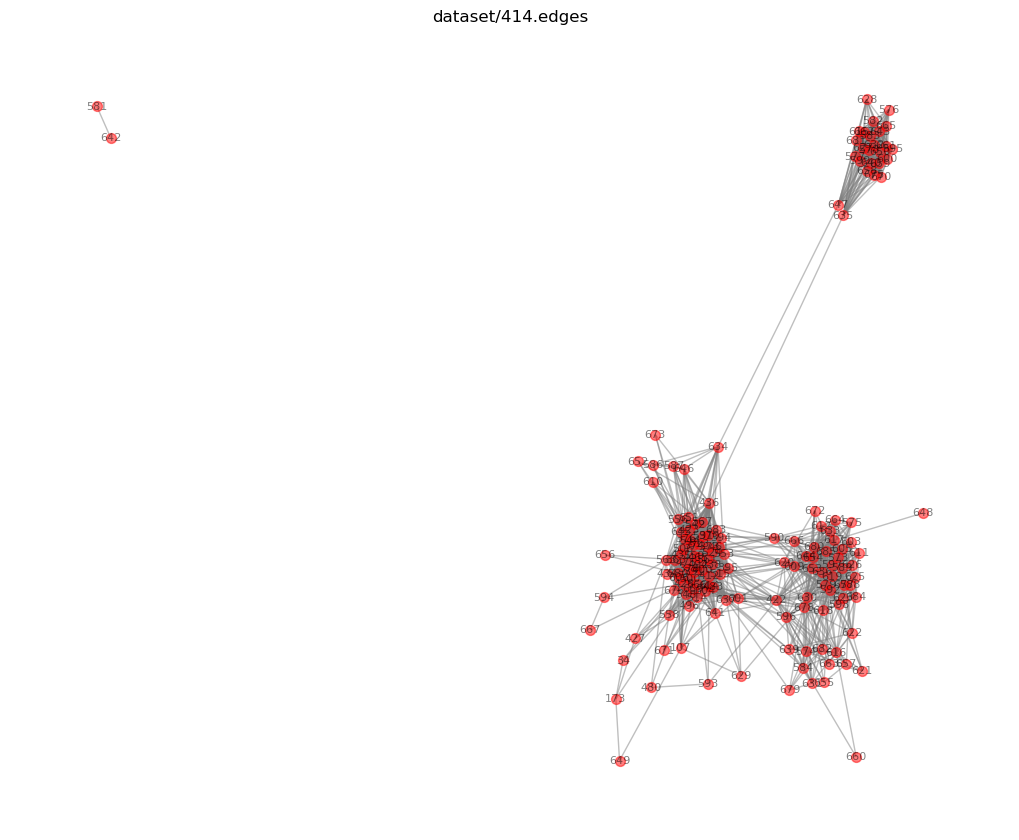

Plotting Eigen Values


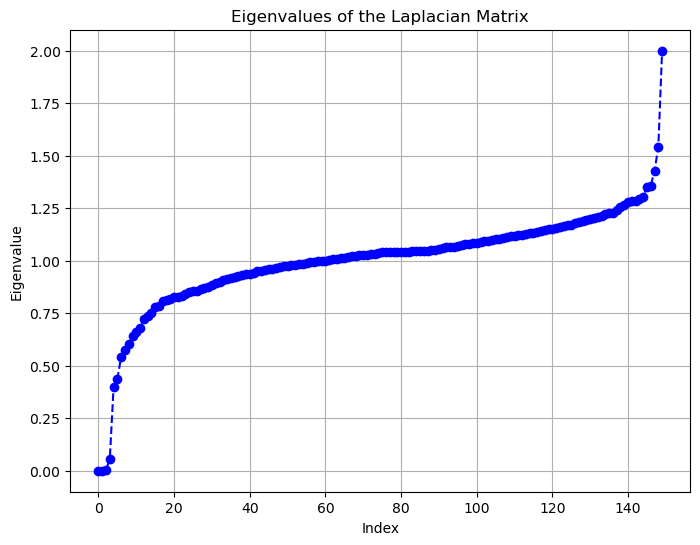

K value chosen after gap:  149
Visualization of Clusters after Spectral Clustering for:  dataset/414.edges


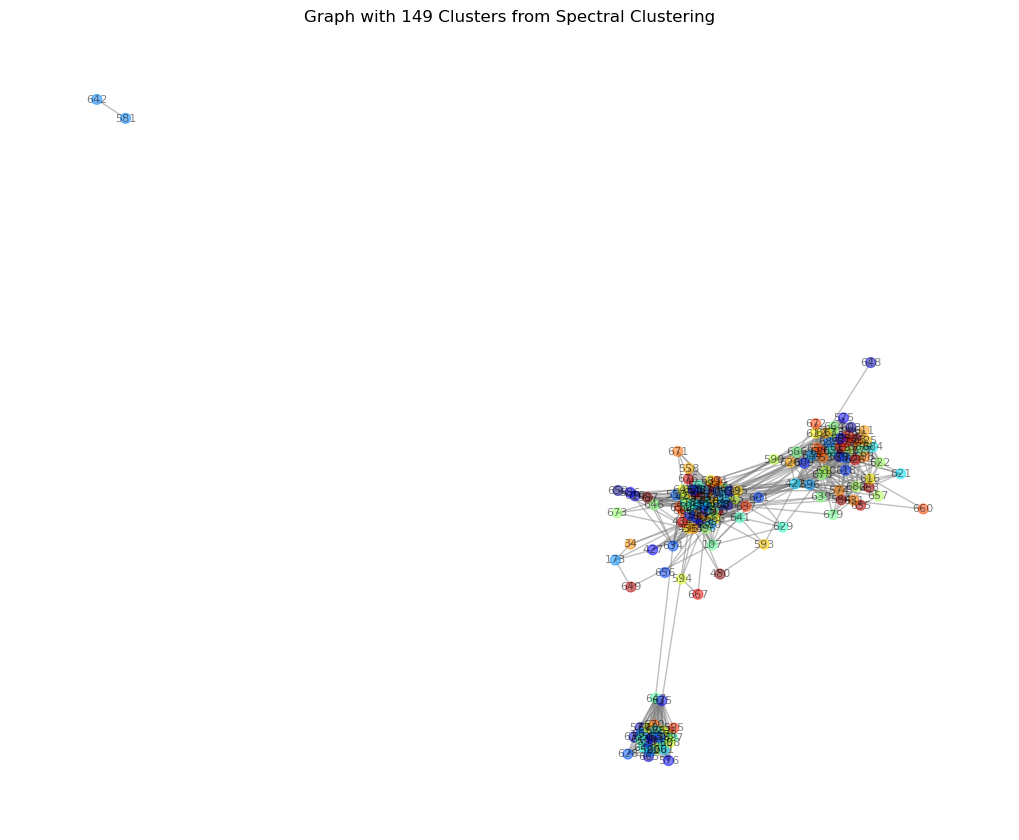

Silhouette Score: 0.0133
Modularity: -0.0083
True Labels (as dict):  {475: 1, 373: 1, 461: 1, 391: 1, 376: 1, 524: 1, 348: 2, 436: 1, 378: 1, 412: 1, 513: 1, 438: 1, 669: 1, 553: 1, 514: 1, 558: 2, 651: 1, 431: 1, 683: 1, 614: 1, 506: 1, 544: 1, 668: 1, 363: 1, 400: 1, 542: 1, 637: 6, 566: 1, 559: 1, 395: 1, 428: 2, 500: 4, 606: 1, 604: 2, 591: 1, 567: 2, 607: 2, 374: 1, 465: 1, 580: 1, 496: 1, 492: 1, 370: 1, 641: 6, 423: 1, 601: 6, 394: 1, 676: 1, 107: 6, 515: 1, 590: 6, 674: 6, 563: 2, 483: 6, 434: 1, 561: 1, 556: 1, 649: 2, 594: 2, 173: 2, 427: 2, 667: 2, 611: 6, 603: 6, 597: 6, 579: 6, 592: 6, 684: 6, 677: 6, 647: 4, 583: 4, 661: 4, 578: 4, 576: 4, 615: 4, 600: 4, 595: 4, 582: 4, 599: 4, 635: 4, 632: 4, 675: 4, 662: 4, 670: 4, 628: 4, 658: 4, 643: 4, 659: 4, 577: 4, 665: 4, 681: 4, 640: 4, 650: 4, 627: 4, 631: 6, 584: 6, 602: 6, 639: 6, 678: 6, 682: 6, 660: 5, 616: 6, 679: 6, 622: 6, 621: 6, 596: 6, 636: 6, 680: 6, 625: 6, 619: 6, 620: 6, 609: 6, 588: 6, 618: 6, 573: 6, 629: 6, 66

In [144]:
perform_spectral_clustering("dataset/414.edges","dataset/414.circles")

#### 686 Edge Network

Visualization for The  dataset/686.edges


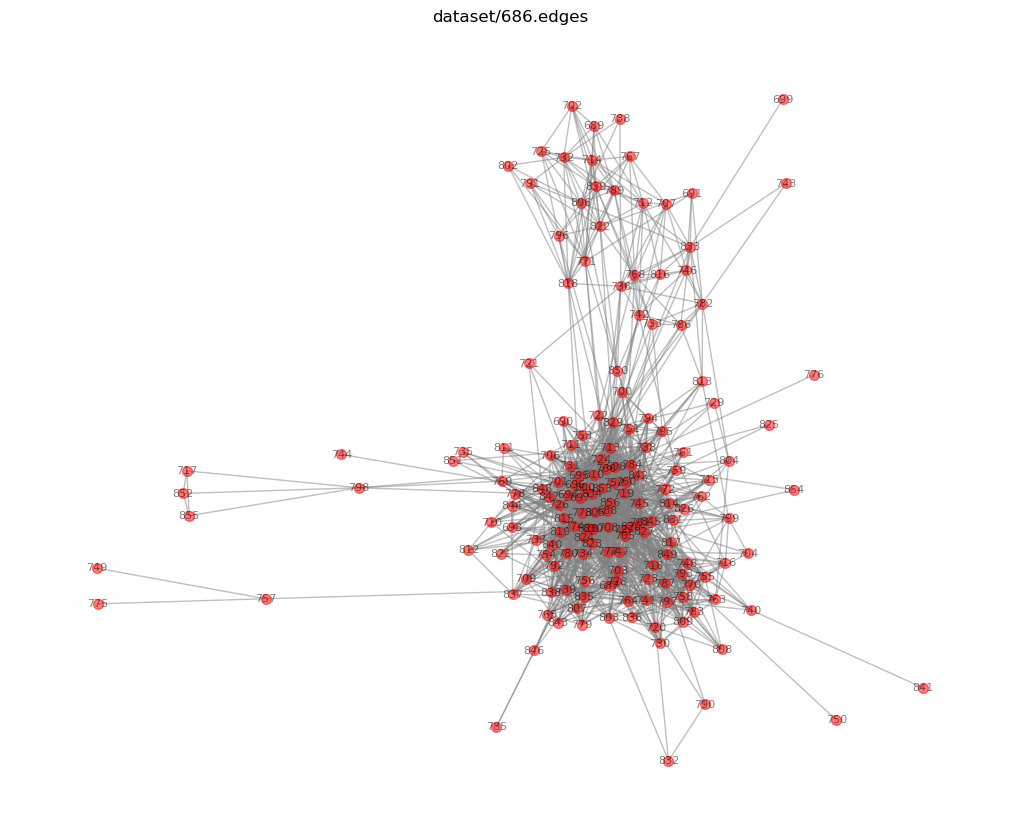

Plotting Eigen Values


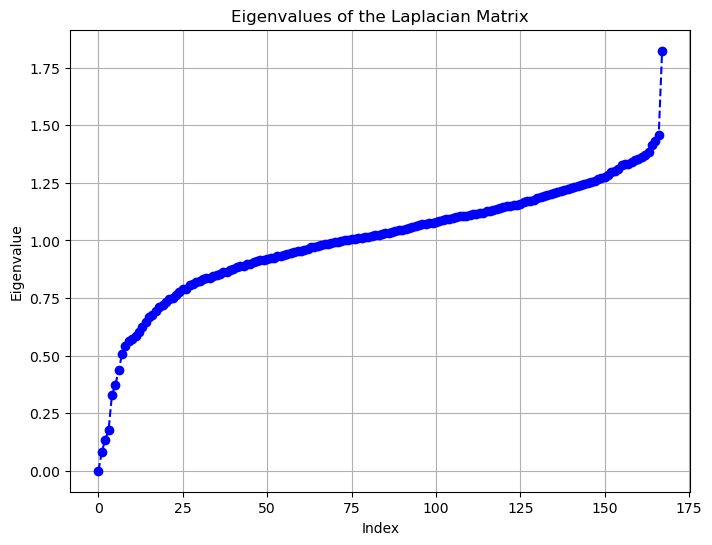

K value chosen after gap:  167
Visualization of Clusters after Spectral Clustering for:  dataset/686.edges


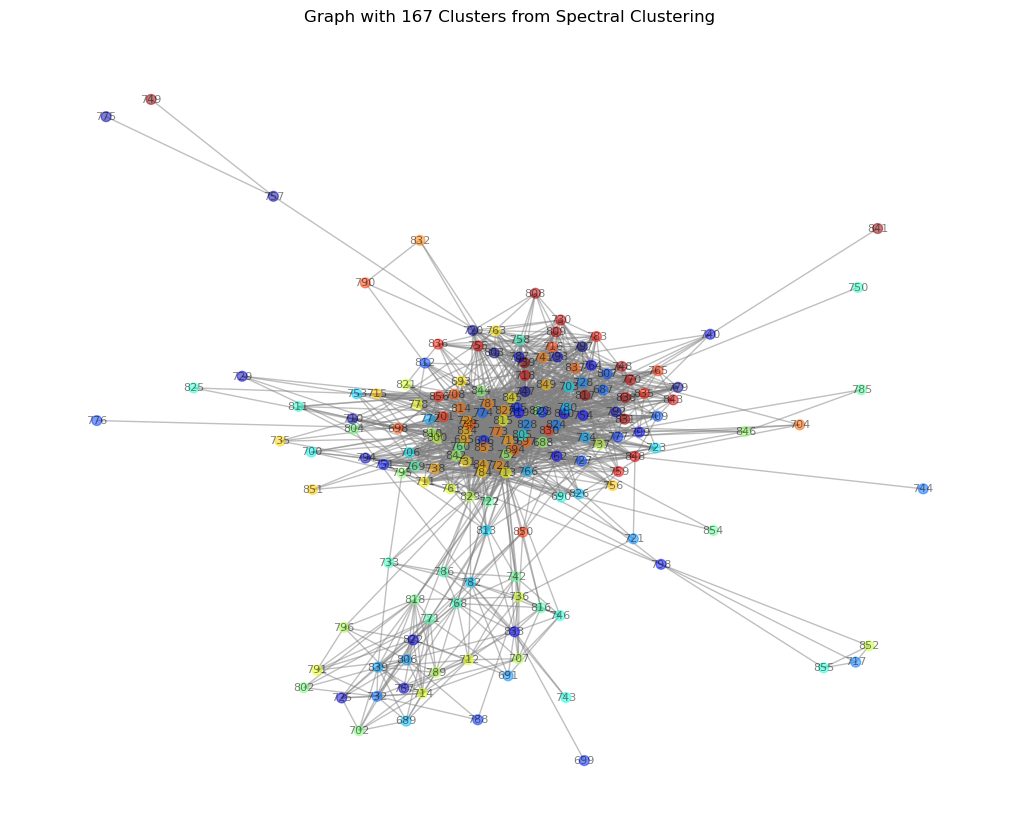

Silhouette Score: 0.0026
Modularity: -0.0093
True Labels (as dict):  {783: 13, 717: 13, 837: 13, 843: 13, 797: 12, 728: 13, 831: 0, 803: 12, 823: 13, 705: 13, 763: 12, 820: 12, 748: 0, 824: 13, 745: 13, 856: 13, 697: 13, 804: 0, 730: 12, 709: 13, 849: 12, 719: 13, 737: 13, 755: 13, 817: 9, 836: 13, 765: 0, 716: 13, 769: 9, 782: 9, 747: 13, 774: 9, 770: 12, 718: 4, 841: 12, 792: 9, 720: 12, 781: 13, 808: 13, 838: 13, 764: 9, 819: 4, 807: 4, 708: 13, 840: 4, 698: 13, 852: 13, 780: 13, 814: 13, 809: 13, 687: 4, 828: 13, 830: 9, 754: 4, 759: 7, 739: 12, 827: 13, 815: 13, 700: 0, 758: 13, 787: 13, 798: 13, 779: 13, 835: 13, 703: 4, 790: 13, 741: 12, 793: 12, 832: 12, 812: 13, 805: 13, 775: 8, 722: 9, 771: 11, 768: 9, 813: 9, 746: 9, 854: 9, 733: 9, 786: 9, 789: 13, 691: 11, 806: 11, 742: 9, 850: 11, 757: 8, 833: 9, 736: 9, 816: 9, 743: 9, 776: 2, 788: 9, 796: 9, 725: 11, 707: 9, 818: 11, 732: 9, 802: 11, 699: 9, 702: 13, 714: 11, 712: 9, 810: 9, 822: 13, 839: 11, 689: 9, 791: 13, 767: 9, 72

In [145]:
perform_spectral_clustering("dataset/686.edges","dataset/686.circles")

#### 698 Edge Network

Visualization for The  dataset/698.edges


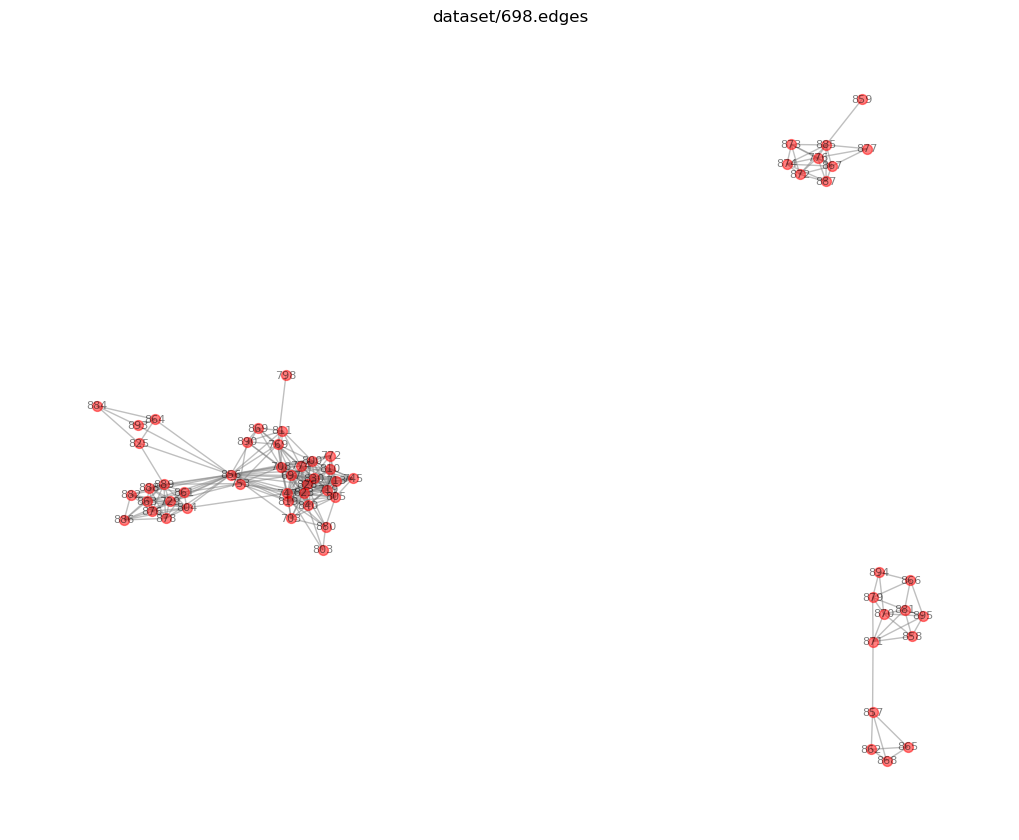

Plotting Eigen Values


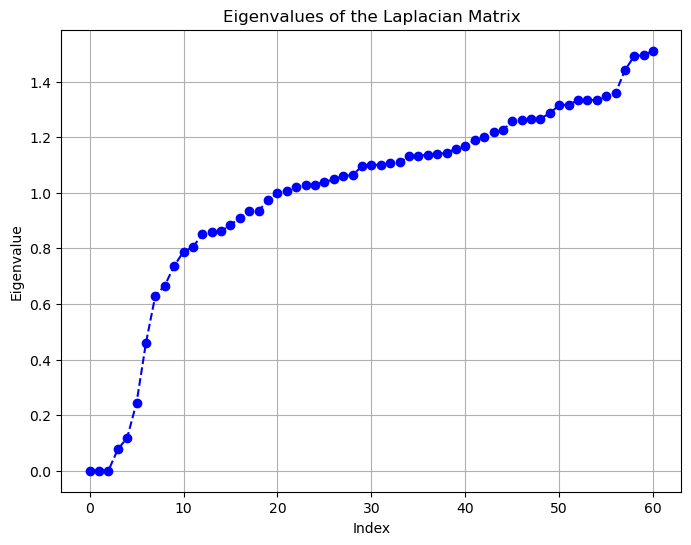

K value chosen after gap:  6
Visualization of Clusters after Spectral Clustering for:  dataset/698.edges


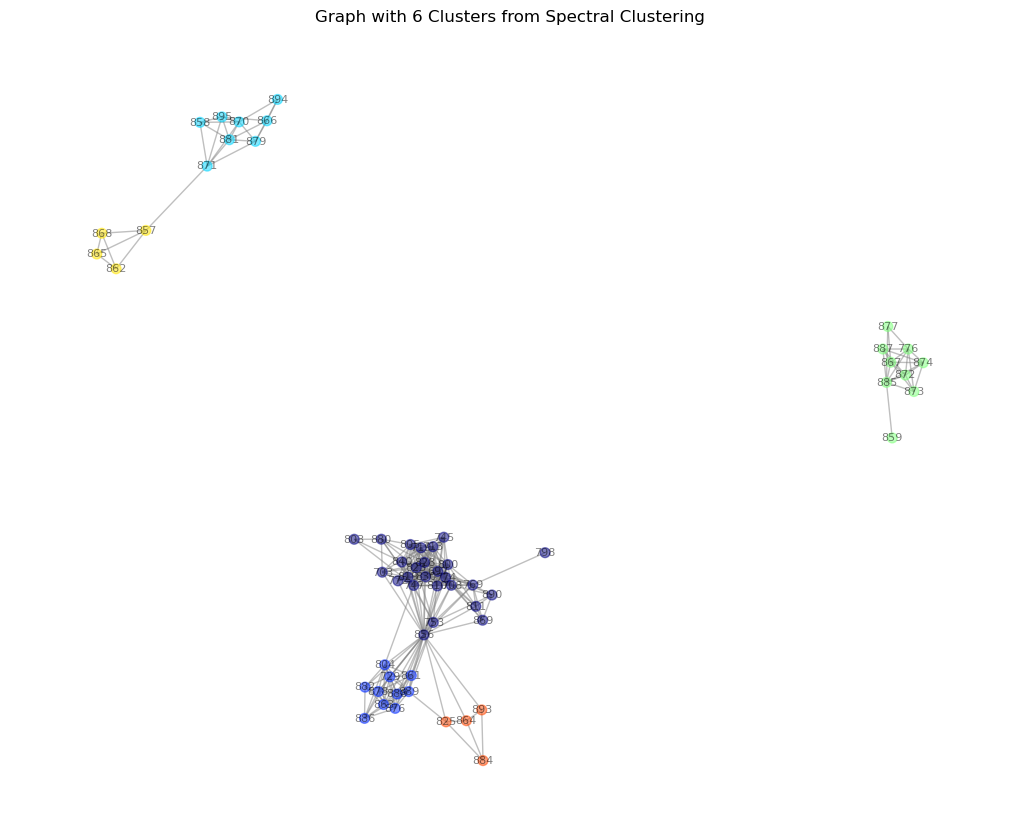

Silhouette Score: 0.8023
Modularity: 0.5107
True Labels (as dict):  {828: 2, 830: 0, 708: 2, 713: 0, 840: 2, 803: 0, 747: 11, 774: 4, 823: 2, 745: 2, 856: 4, 697: 9, 719: 0, 882: 3, 863: 3, 888: 3, 753: 1, 729: 3, 864: 1, 884: 1, 878: 3, 825: 1, 876: 7, 886: 3, 889: 7, 875: 3, 893: 1, 804: 3, 880: 2, 800: 2, 772: 2, 810: 10, 805: 2, 879: 5, 870: 5, 858: 5, 871: 10, 881: 5, 866: 5, 895: 5, 862: 10, 776: 8, 857: 6, 872: 8, 867: 8, 877: 8, 874: 8, 873: 8, 887: 8, 885: 8, 868: 10, 865: 10, 860: 12, 883: 12}
NMI: 0.0000
ARI: 0.0000
Average Intra-Cluster Distance: 0.0575
Average Inter-Cluster Distance: 0.4840


In [146]:
perform_spectral_clustering("dataset/698.edges","dataset/698.circles")

#### 1684 Edge Network

Visualization for The  dataset/1684.edges


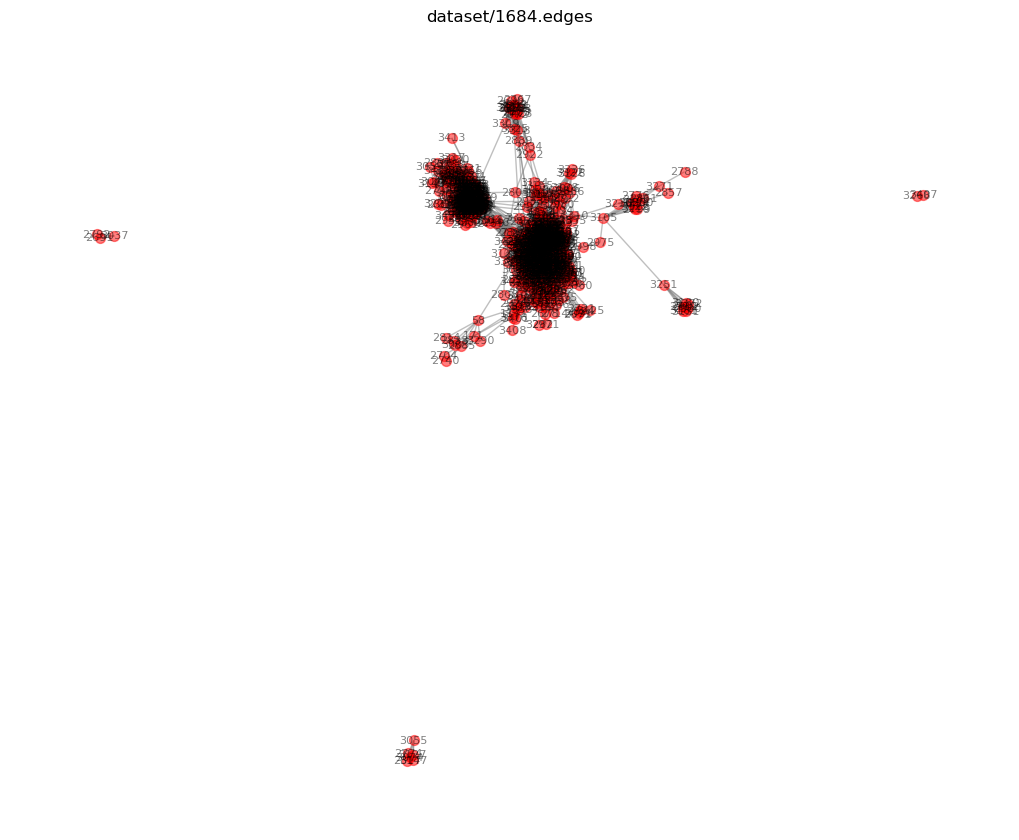

Plotting Eigen Values


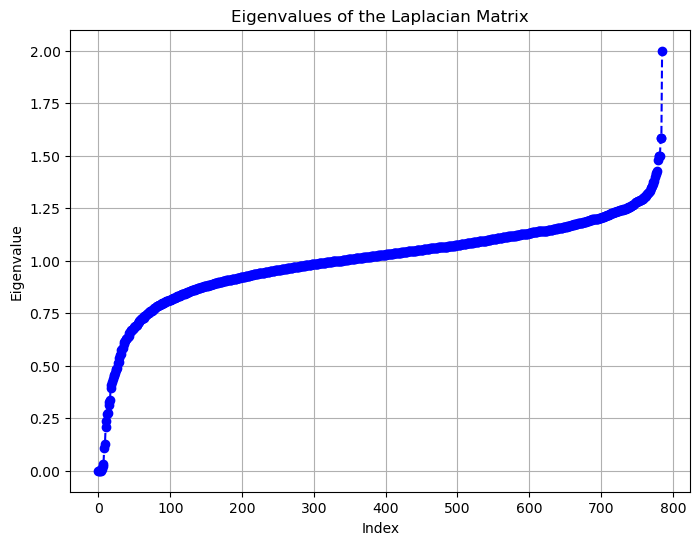

K value chosen after gap:  785
Visualization of Clusters after Spectral Clustering for:  dataset/1684.edges


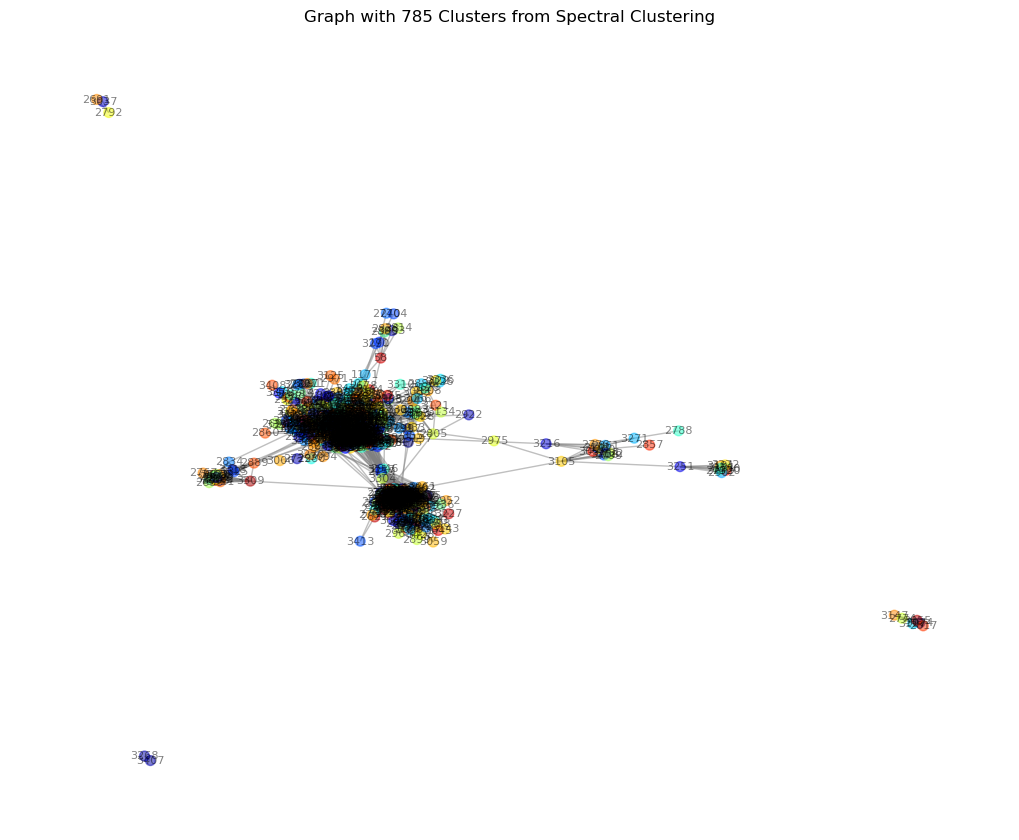

Silhouette Score: 0.0025
Modularity: -0.0020
True Labels (as dict):  {2900: 0, 3077: 0, 2934: 0, 3186: 0, 2870: 0, 3162: 0, 3207: 0, 2947: 0, 3001: 0, 3118: 0, 3177: 0, 3410: 0, 2990: 0, 2860: 0, 3420: 0, 3176: 0, 3356: 0, 2775: 0, 2739: 0, 3371: 0, 3191: 0, 2696: 0, 3018: 0, 2724: 0, 2728: 0, 3007: 0, 3068: 0, 3412: 0, 2711: 0, 3019: 0, 2951: 0, 2737: 0, 2892: 0, 3002: 0, 3366: 0, 2830: 0, 3223: 0, 1405: 0, 2779: 0, 3379: 0, 2962: 0, 2662: 0, 2682: 0, 3415: 0, 3295: 0, 2829: 0, 2820: 0, 3334: 0, 3210: 0, 3103: 0, 2713: 0, 2671: 0, 3285: 0, 3069: 0, 3086: 0, 3244: 0, 3273: 0, 2995: 0, 3154: 0, 3100: 0, 3246: 0, 2845: 0, 3203: 0, 3346: 0, 3359: 0, 3168: 0, 3233: 0, 2697: 0, 3062: 0, 3241: 0, 860: 1, 2885: 1, 2814: 1, 2717: 1, 2838: 1, 2740: 1, 2704: 1, 3003: 1, 58: 1, 3290: 1, 171: 1, 2785: 2, 3175: 2, 3111: 2, 2849: 2, 2708: 2, 3013: 2, 3272: 2, 3224: 2, 2992: 2, 3079: 2, 3386: 2, 2904: 2, 2797: 2, 3360: 2, 2833: 2, 2778: 2, 2875: 2, 3422: 2, 3434: 2, 2869: 2, 2720: 2, 3396: 2, 3206: 2

In [147]:
perform_spectral_clustering("dataset/1684.edges","dataset/1684.circles")

#### 1912 Edge Network

Visualization for The  dataset/1912.edges


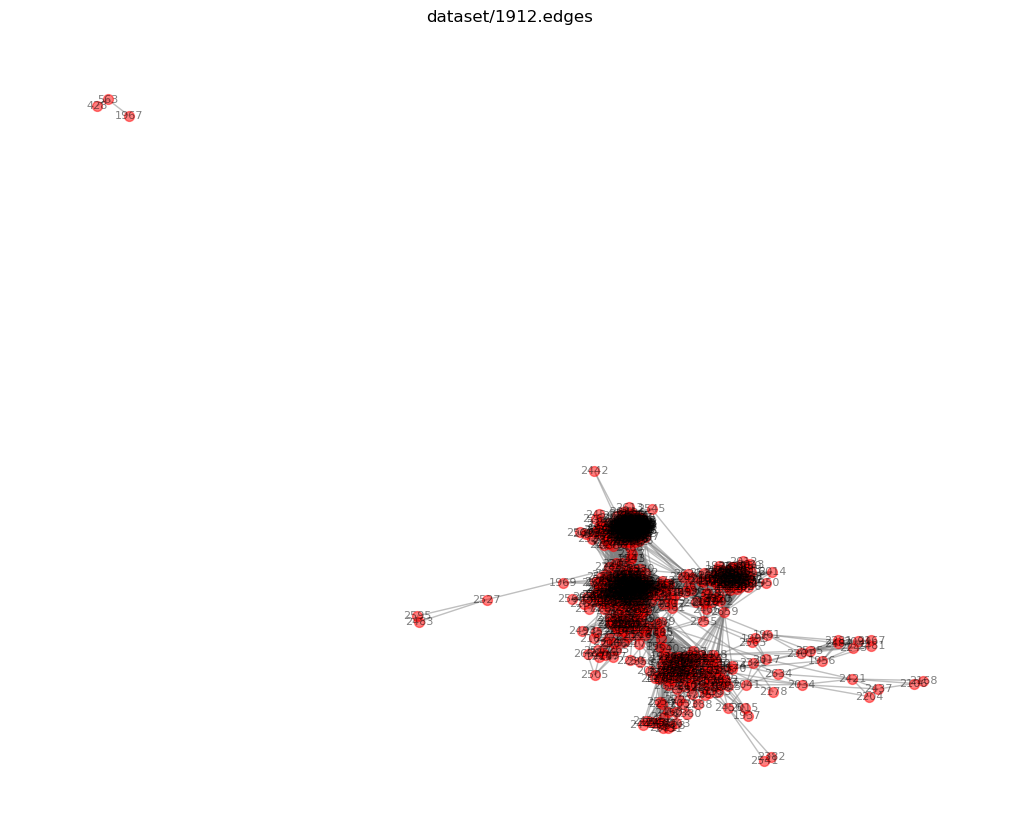

Plotting Eigen Values


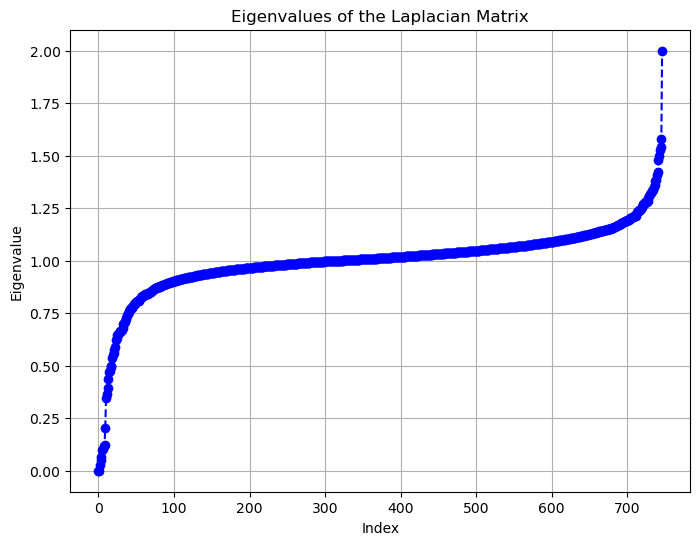

K value chosen after gap:  746
Visualization of Clusters after Spectral Clustering for:  dataset/1912.edges


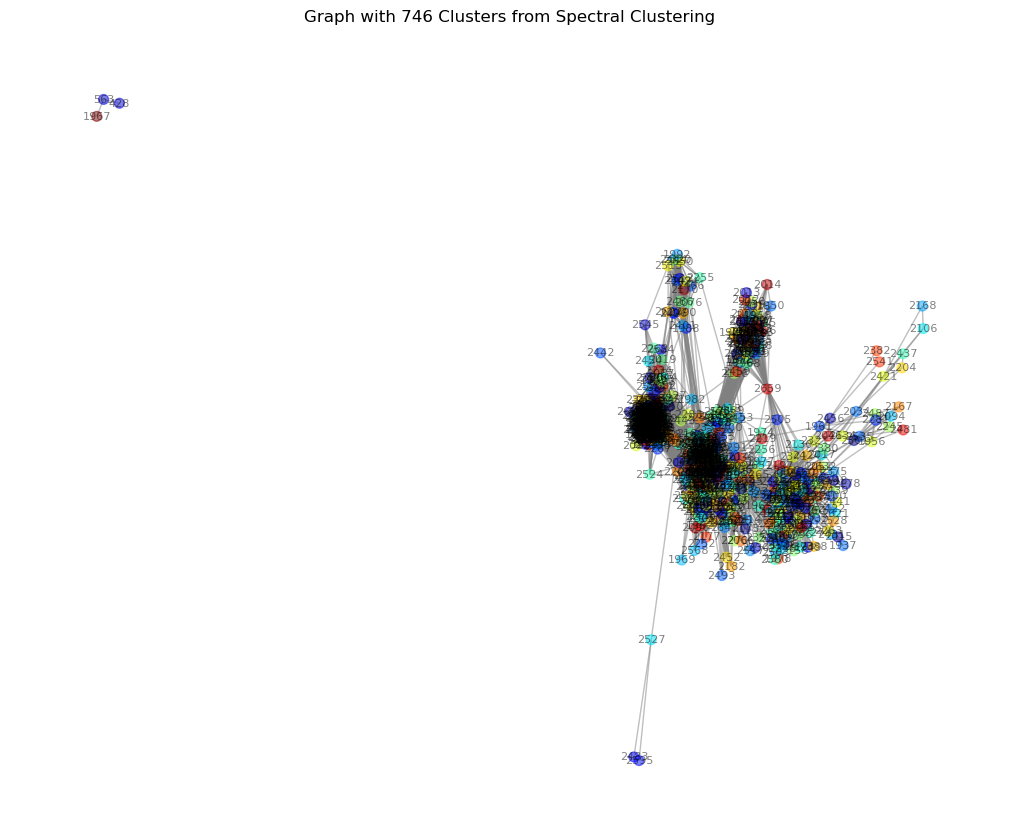

Silhouette Score: 0.0006
Modularity: -0.0022
True Labels (as dict):  {2540: 41, 2047: 41, 2543: 38, 2332: 38, 2183: 38, 2094: 34, 1941: 38, 2014: 1, 2571: 38, 2009: 1, 2011: 1, 2657: 1, 1931: 1, 2639: 1, 2640: 1, 2645: 1, 1999: 15, 2000: 1, 1998: 1, 2284: 1, 2585: 1, 2001: 1, 2020: 20, 2192: 1, 2159: 1, 2024: 1, 2297: 1, 1921: 1, 1995: 1, 2004: 1, 2378: 1, 2006: 1, 2346: 1, 2116: 1, 2648: 1, 2647: 1, 2459: 43, 2337: 1, 2022: 1, 2658: 1, 2660: 1, 2659: 41, 2018: 1, 2268: 38, 2633: 1, 1976: 42, 2341: 41, 1968: 1, 1927: 1, 1954: 38, 2447: 1, 1928: 1, 2157: 1, 2472: 38, 1991: 1, 1950: 1, 2627: 1, 2626: 1, 1914: 1, 2016: 1, 2012: 1, 136: 38, 2364: 1, 2636: 1, 2494: 1, 2015: 1, 2097: 1, 2620: 1, 2583: 1, 1951: 1, 2538: 1, 1935: 1, 2143: 38, 2025: 1, 2027: 1, 2171: 1, 1919: 1, 2456: 41, 2108: 20, 2369: 20, 2046: 20, 2059: 20, 2439: 16, 2531: 42, 2185: 4, 2254: 38, 2548: 16, 2461: 38, 2558: 13, 2375: 16, 2219: 4, 2217: 16, 2621: 16, 2567: 38, 2026: 36, 2191: 38, 2153: 38, 2498: 41, 1959: 29, 1

In [148]:
perform_spectral_clustering("dataset/1912.edges","dataset/1912.circles")

Visualization for The  dataset/3437.edges


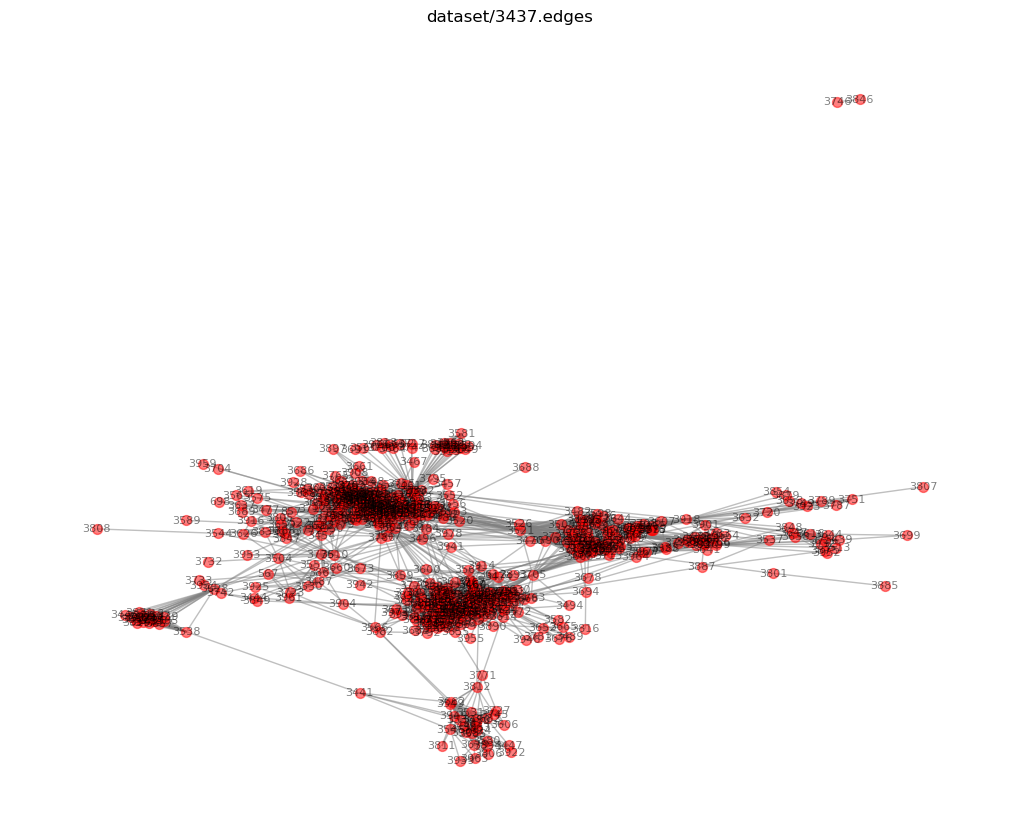

Plotting Eigen Values


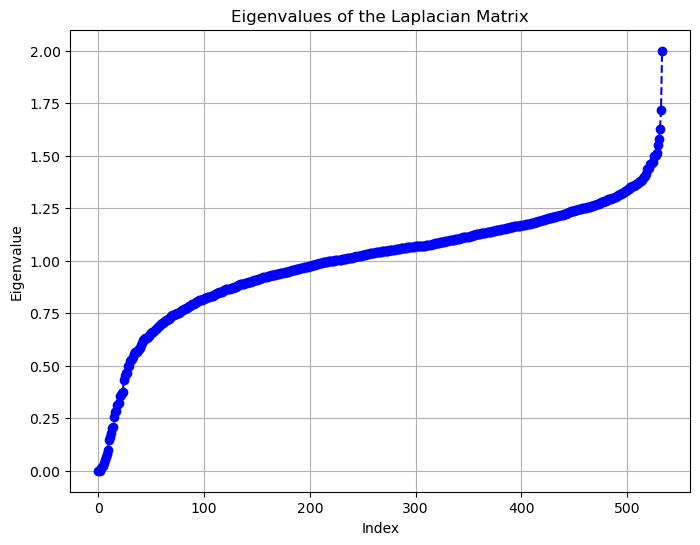

K value chosen after gap:  533
Visualization of Clusters after Spectral Clustering for :  dataset/3437.edges


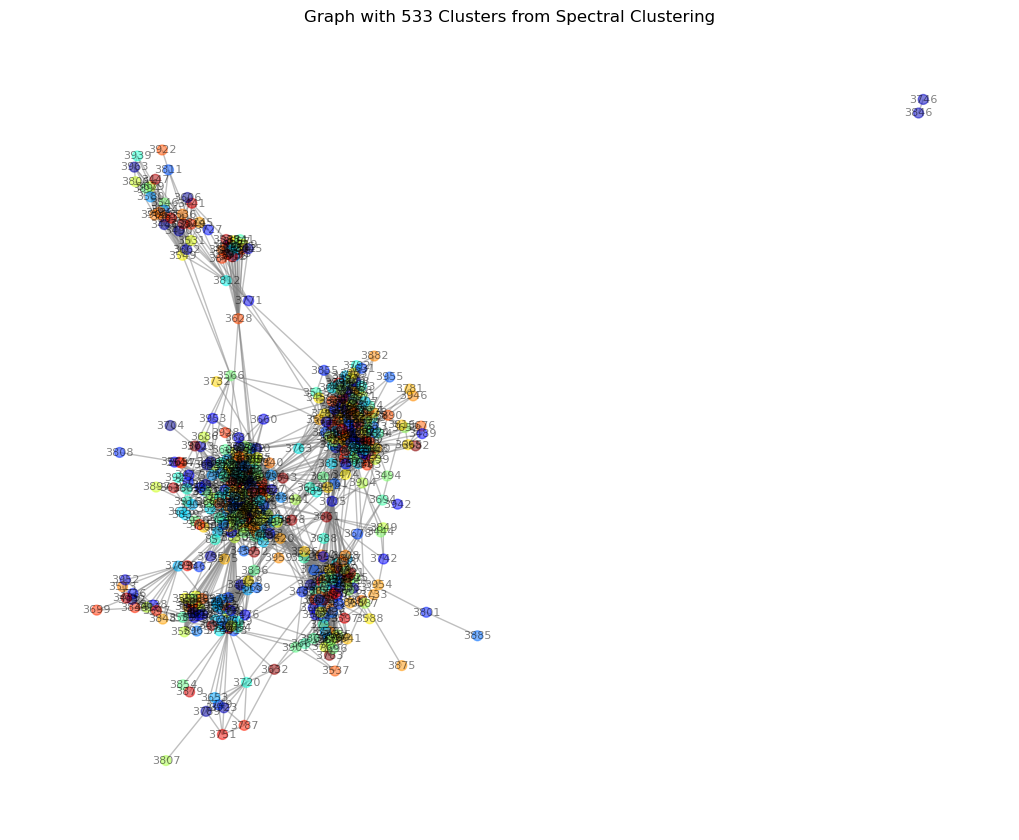

Silhouette Score: 0.0037
Modularity: -0.0029
Average Intra-Cluster Distance: 0.0000
Average Inter-Cluster Distance: 1.4131


In [102]:
perform_spectral_clustering("dataset/3437.edges")

#### 3980 Edge Network

Visualization for The  dataset/3980.edges


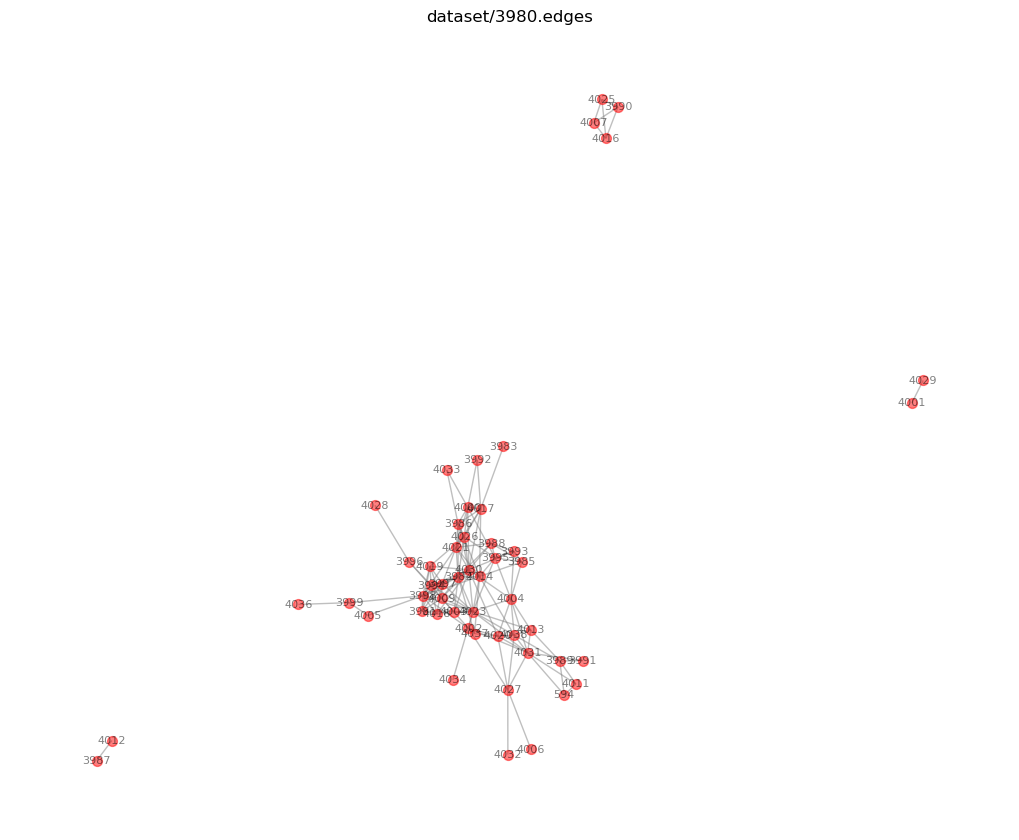

Plotting Eigen Values


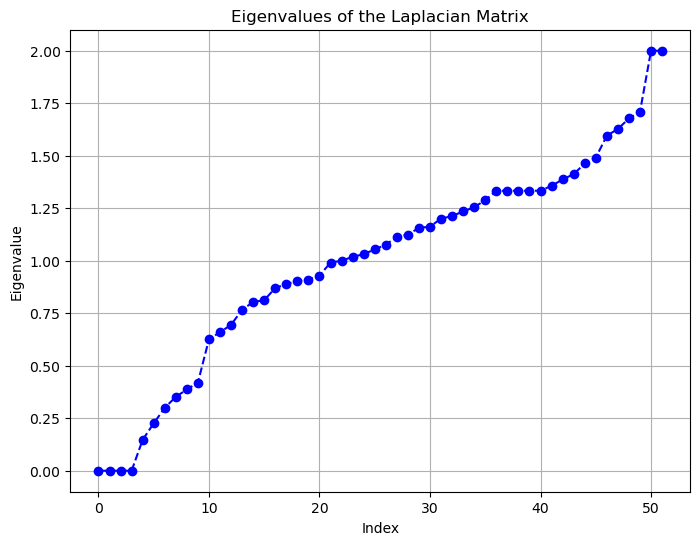

K value chosen after gap:  50
Visualization of Clusters after Spectral Clustering for:  dataset/3980.edges


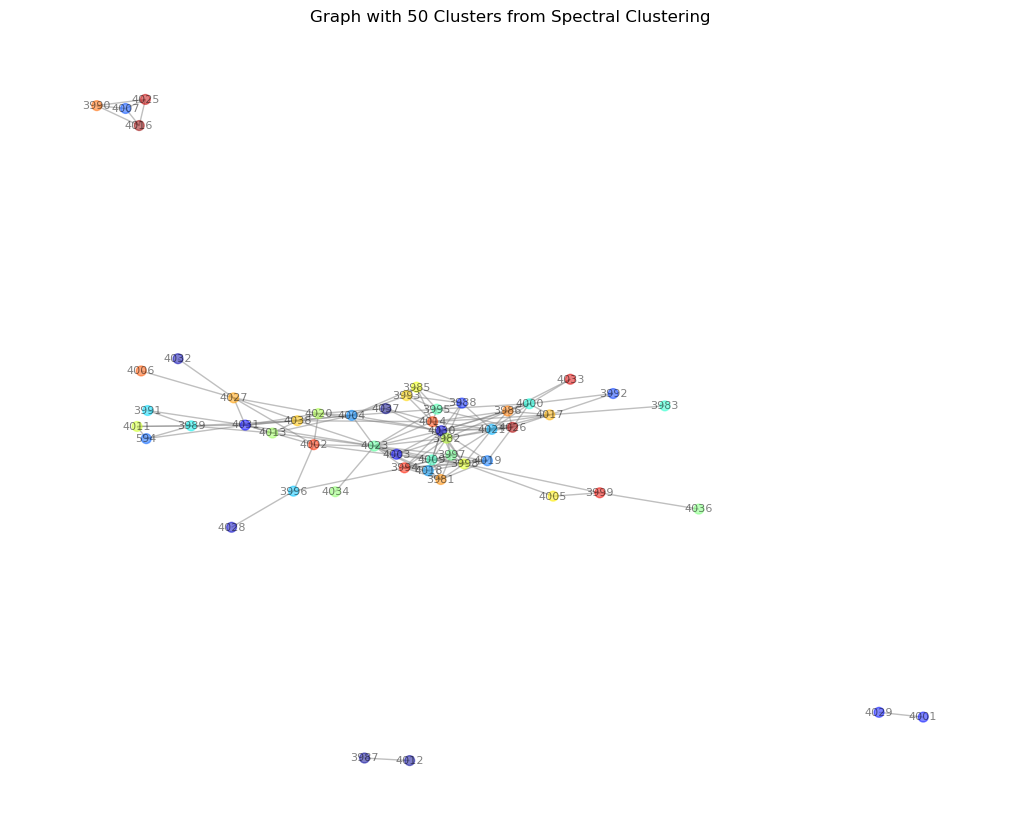

Silhouette Score: 0.0769
Modularity: -0.0160
True Labels (as dict):  {3989: 0, 4009: 0, 4010: 1, 4037: 1, 4013: 2, 4024: 3, 3987: 3, 4015: 3, 4006: 4, 4035: 5, 3999: 6, 4028: 6, 4005: 6, 3996: 6, 4031: 6, 4018: 6, 3994: 6, 4002: 6, 4032: 6, 3991: 6, 3981: 6, 3998: 6, 4036: 6, 4023: 6, 3997: 6, 4011: 6, 4019: 6, 594: 6, 4027: 6, 4008: 6, 4020: 6, 4034: 6, 3984: 7, 3988: 8, 4030: 8, 4026: 8, 4021: 8, 3983: 9, 3992: 9, 4033: 9, 4017: 9, 4000: 9, 3986: 9, 3990: 10, 4007: 10, 4016: 10, 4025: 10, 4001: 11, 4029: 11, 4012: 12, 4038: 13, 4014: 14, 3982: 15, 4003: 16, 3995: 16, 3993: 16, 4004: 16, 3985: 16}
NMI: 0.0000
ARI: 0.0000
Average Intra-Cluster Distance: 0.0000
Average Inter-Cluster Distance: 1.3920


In [149]:
perform_spectral_clustering("dataset/3980.edges","dataset/3980.circles")